In [ ]:
import re
import requests
from bs4 import BeautifulSoup
import heapq
import matplotlib.pyplot as plt
import numpy as np
import json

def get_all_new_replays(url, data, url_latest): # url_latest: "https://wank.wavu.wiki/api", url: "#"https://wank.wavu.wiki/api/replays"
    
    break_point = 0
    for d in data:
        break_point = max(d["battle_at"], break_point)
    
    before = get_latest_api_entry(url_latest)
    replays = []
    log = 1
    
    while True:
        res = requests.get(url, params={"before": before}).json()
        if not res or before <= break_point:
            print(f"sth went wrong or reached the end\n"
                  f"new entries: {len(replays)}\n"
                  f"latest: {break_point}\n"
                  f"was searching for time: {before}")
            break
        
        replays.extend(res)
            
        before = min(float(r["battle_at"]) for r in res) - 700
        if log % 10 == 0:
            print(f"fetched {len(replays)}")
        
        log += 1
    
    return replays
        


def get_latest_api_entry(url): #"https://wank.wavu.wiki/api"
    text = ""

    response = requests.get(url)
    if response.status_code == 200:
        soup = BeautifulSoup(response.text, "html.parser")
        
        main_section = soup.find("main", class_="document")
        if main_section:
            dl_tag = main_section.find("dl")
            if dl_tag:
                dd_tags = dl_tag.find_all("dd")
                text = dd_tags[0].text.strip()
            else:
                print("No <dl> tag found in <main class='document'>.")
        else:
            print("No <main class='document'> tag found.")
    else:
        print(f"Failed to fetch the page. Status code: {response.status_code}")
    
    m = re.search(r"default:\s*(\d+)", text)
    max_entry = 0
    
    if m:
        max_entry = m.group(1)

    return int(max_entry) if int(max_entry) > 0 else -1


def find_all_replays_for_id(player_id, data, player_polaris_id=None): # my id is 5r4gQ4RNgNQ4

    max_index = 40
    most_used = [0] * (max_index + 1)
    most_played_against = [0] * (max_index + 1)
    won = 0
    defect = 0
    raw_data = []

    for d in data:
        if not player_polaris_id:
            if d['p1_name'].lower() == player_id.lower():
                player_polaris_id = d["p1_polaris_id"]
            elif d['p2_name'].lower() == player_id.lower():
                player_polaris_id = d["p2_polaris_id"]
        else:            
            if d["p1_polaris_id"] == player_polaris_id:
                most_used[d["p1_chara_id"]] += 1
                most_played_against[d["p2_chara_id"]] += 1
                if d["winner"] == 1:
                    won += 1
            elif d["p2_polaris_id"] == player_polaris_id:
                most_used[d["p2_chara_id"]] += 1
                most_played_against[d["p1_chara_id"]] += 1
                if d["winner"] == 2:
                    won += 1
            
            raw_data.append(d)
                

    player_data = {"most_used_arr": most_used,
                "most_played_against": most_played_against,
                "win_rate": f"{won / (len(data) - defect) * 100}%"}

    
    return player_data, raw_data

def plot_user_most_played_against(user_data, playable_char_map, unused_idxs):
    x = [""] * (len(user_data["most_played_against"]))
    play_data = []
    
    for i, x in enumerate(user_data["most_played_against"]):
        heapq.heappush(play_data, (-x, i))

    x = []
    y = []
    
    while play_data:
        v, i = heapq.heappop(play_data)
        if i in unused_idxs:
            continue
        y.append(-v)
        x.append(playable_char_map[i])
        
    most_used_np = np.array(x)
    most_used_y = np.array(y)

    plt.figure(figsize=(20, 5))
    x_positions = np.arange(len(most_used_np))
    plt.bar(most_used_np, most_used_y, width=0.5)
    plt.xticks(x_positions, most_used_np, rotation=60)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.title("most played against")
    plt.show()


def plot_user_most_used_chars_data(user_data, playable_char_map, unsused_idxs):
    play_data = []
    
    for i, x in enumerate(user_data["most_used_arr"]):
        heapq.heappush(play_data, (-x, i))
    
    x = []
    y = []
    
    while play_data:
        v, i = heapq.heappop(play_data)
        if i in unsused_idxs:
            continue
        y.append(-v)
        x.append(playable_char_map[i])
    
    most_used_np = np.array(x)
    most_used_y = np.array(y)

    plt.figure(figsize=(20, 5))
    x_positions = np.arange(len(most_used_np))
    plt.bar(most_used_np, most_used_y, width=0.5)
    plt.xticks(x_positions, most_used_np, rotation=45)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.title("character usage data")
    plt.show()


def head_to_head_char_win_rates(indv_matchups, playable_char_map, unused_idxs, reverse_char_map):

    length = len(playable_char_map) - len(unused_idxs)
    matchup_winrates = [[0.0 for _ in range(length)] for _ in range(length)]

    off = 0
    for name, v in indv_matchups.items():
        apps, wins = v[0], v[1]
        idx = reverse_char_map[name]
        off_i = 0
        if idx == 28:
            off = 3
        elif idx == 32:
            off = 5
        elif 38 == idx:
            off = 6
        for i in range(len(apps)):
            if i in unused_idxs:
                off_i += 1
                continue
            
            if idx == i:
                matchup_winrates[idx - off][i - off_i] = 50
            else:
                wr = (wins[i] / apps[i]) * 100
                matchup_winrates[idx - off][i - off_i] = wr
    
    
    return matchup_winrates

def find_char_popularity(data, playable_char_map):
    
    char_data = [0] * 41
    not_found = set()
    flag = False
    for d in data:
        flag = False
        if d["p2_chara_id"] not in playable_char_map.keys():
            not_found.add(d["p2_chara_id"])
            flag = True
        
        elif d["p1_chara_id"] not in playable_char_map.keys():
            not_found.add(d["p1_chara_id"])
            flag = True
        
        if not flag:
            char_data[d["p1_chara_id"]] += 1
            char_data[d["p2_chara_id"]] += 1
    
    return char_data, list(not_found)


def get_chars_ind_matchups_winrates(data, playable_char_map, unused_idxs):
    
    max_idx = max(playable_char_map.keys())    
    individual = {}
    
    for i, char in playable_char_map.items():
        if i in unused_idxs:
            continue
        
        individual[char] = [[0] * (max_idx + 1), [0] * (max_idx + 1)]
        
    for d in data:
        p1_char = d["p1_chara_id"]
        p2_char = d["p2_chara_id"]
        
        char_1_app, char_1_win = individual[playable_char_map[p1_char]]
        char_2_app, char_2_win = individual[playable_char_map[p2_char]]
        
        char_1_app[p2_char] += 1
        char_2_app[p1_char] += 1
        
        if d["winner"] == 1:
            char_1_win[p2_char] += 1
        elif d["winner"] == 2:
            char_2_win[p1_char] += 1
        
        individual[playable_char_map[p1_char]] = [char_1_app, char_1_win]
        individual[playable_char_map[p2_char]] = [char_2_app, char_2_win]
    
    return individual


def get_chars_global_winrates(data, playable_char_map):
    max_idx = max(playable_char_map.keys())
    appearance = [0] * (max_idx + 1)
    char_wins = [0] * (max_idx + 1)
    
    for d in data:
        appearance[d["p1_chara_id"]] += 1
        appearance[d["p2_chara_id"]] += 1
        
        if d["winner"] == 1:
            char_wins[d["p1_chara_id"]] += 1
        else:
            char_wins[d["p2_chara_id"]] += 1
    
    return appearance, char_wins


def plot_data(data, playable_char_map, unused_idxs, title, percentage=False):
    pop_data = []
    total = sum(data)
    y_label = "usage"
    if percentage:
        y_label += " percentage"
        title += " percentage"

    for i in range(len(data)):
        if i in unused_idxs:
            continue
        
        heapq.heappush(pop_data, (data[i] * -1, playable_char_map[i]))

    x = []
    y = []
    
    while pop_data:
        pop, char = heapq.heappop(pop_data)
        x.append(char)
        if percentage:
            y.append(((-1 * pop) / total) * 100)
        else:
            y.append(-1 * pop)

    most_used_np = np.array(x)
    most_used_y = np.array(y)

    plt.figure(figsize=(20, 5))
    x_positions = np.arange(len(most_used_np))
    plt.bar(most_used_np, most_used_y, width=0.5)
    plt.xticks(x_positions, most_used_np, rotation=45)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.ylabel(y_label)
    plt.title(title)
    plt.show()


def get_ranked_data(data):
    
    rank_data = [0] * 30
    
    for d in data:
        rank_data[d['p1_rank']] += 1
        rank_data[d['p2_rank']] += 1
    
    return rank_data

def plot_rank_data(data, rank_mapping, percentage=False):
    x = [""] * 30
    y = [0] * 30
    t = sum(data)
    title = "rank distribution"
    
    if percentage:
        title += " expressed as percentage"
    
    for i in range(len(data)):
        x[i] = rank_mapping[i]
        if percentage:
            y[i] = (data[i] / t) * 100
        else:
            y[i] = data[i]
    
    x = np.array(x)
    y = np.array(y)
    
    plt.figure(figsize=(20, 5))
    x_positions = np.arange(len(data))
    plt.bar(x, y, width=0.5)
    plt.xticks(x_positions, x, rotation=60)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.ylim(0, 12)
    plt.title(title)
    plt.show()


def plot_char_matchup_winrates(data, playable_char_map, unused_idxs, title, sort=False):
    
    win_rates = [0.0] * 41
    for i in range(len(data[0])):
        if i in unused_idxs or data[0][i] == 0:
            continue
        
        win_rates[i] = data[1][i] / data[0][i]

    x = []
    y = []
    if sort:
        pop_data = []
        for i in range(len(win_rates)):
            if i in unused_idxs:
                continue
            
            heapq.heappush(pop_data, (-win_rates[i] * 100, i))
        
        while pop_data:
            w, i = heapq.heappop(pop_data)
            x.append(playable_char_map[i])
            y.append(-w)
    else:
        for i in range(len(win_rates)):
            if i in unused_idxs:
                continue
            
            x.append(playable_char_map[i])
            y.append(win_rates[i] * 100)
        
            
            
    
    char_names = np.array(x)
    char_win_rate_against = np.array(y)
    
    
    plt.figure(figsize=(20, 5))
    x_positions = np.arange(len(char_names))
    plt.bar(char_names, char_win_rate_against, width=0.5)
    plt.xticks(x_positions, char_names, rotation=60)
    plt.ylim(40, 55)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.title(title)
    plt.show()

def plot_global_char_winrates(char_usage, char_wins, unused_idxs, playable_char_map, title, sort=True):
    global_winrates = {}
    for i in range(len(char_usage)):
        if i in unused_idxs:
            continue
        
        char_appear_count = char_usage[i]
        char_win_count = char_wins[i]
        
        global_winrates[playable_char_map[i]] = (char_win_count / char_appear_count) * 100

    
    x = []
    y = []
    if sort:
        winrate_heap = []
        for char, w in global_winrates.items():
            heapq.heappush(winrate_heap, (-w, char))
        
        while winrate_heap:
            w, char = heapq.heappop(winrate_heap)
            x.append(char)
            y.append(-w)
    else:
        for char, w in global_winrates.items():
            x.append(char)
            y.append(w)
    
    char_names = np.array(x)
    char_win_rate = np.array(y)
    
    plt.figure(figsize=(20, 5))
    x_positions = np.arange(len(char_names))
    plt.bar(char_names, char_win_rate, width=0.5)
    plt.xticks(x_positions, char_names, rotation=60)
    plt.ylim(46, 55)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.title(title)
    plt.show()


def plot_heatmap(matchup_winrates, playable_char_map, unused_idxs, title):

    data_s = np.array(matchup_winrates)
    names = []
    for k, v, in playable_char_map.items():
        if k in unused_idxs:
            continue
        
        names.append(v)

    plt.figure(figsize=(20, 16))
    plt.imshow(data_s, cmap="viridis", interpolation="nearest")
    plt.colorbar()

    plt.title(title)
    plt.xlabel("Character")
    plt.ylabel("Character")
        
    plt.xticks(ticks=np.arange(len(names)), labels=names, rotation=90)
    plt.yticks(ticks=np.arange(len(names)), labels=names)

    for i in range(len(data_s)):
        for j in range(len(data_s)):
            plt.text(j, i, f"{data_s[i, j]:.1f}", ha='center', va='center', color='black', fontsize=12)

    plt.tight_layout()
    plt.show()

def filter_data_based_on_rank(data, start_rank=0, stop_rank=29):
    
    filtered_data = []
    
    for d in data:
        if (start_rank <= d["p1_rank"] and stop_rank + 1 > d["p1_rank"]) or (start_rank <= d["p2_rank"] and stop_rank + 1 > d["p2_rank"]):
            filtered_data.append(d)
    
    return filtered_data


def update_local_json_replays(outpath, data):
    with open(outpath, 'w') as f:
        json.dump(data, f, indent=4)

In [2]:
# gets all the data available on wavu wank api


# break_point = 0

# before = get_latest_api_entry(api_url)
# replays = []
# log = 1

# while True:
#     res = requests.get(replay_url, params={"before": before}).json()
#     if not res or before == 0:
#         print(f"sth went wrong or reached the end\n"
#                 f"new entries: {len(replays)}\n"
#                 f"latest: {break_point}\n"
#                 f"was searching for time: {before}")
#         break
    
#     replays.extend(res)
        
#     before = min(float(r["battle_at"]) for r in res) - 700
#     before = max(before, 0)
#     if log % 10 == 0:
#         print(f"fetched {len(replays)}")
    
#     log += 1


# with open("./replays.json", 'w') as f:
#     json.dump(replays, f, indent=4)

In [3]:

replay_url = "https://wank.wavu.wiki/api/replays"
api_url = "https://wank.wavu.wiki/api"
unused_idxs = [25,26,27,30,31,37]
unused_idxs = set(unused_idxs)


rank_mapping = {
    0: "Beginner",
    1: "1st Dan",
    2: "2nd Dan",
    3: "Fighter",
    4: "strategist",
    5: "combatant",
    6: "Brawler",
    7: "Ranger",
    8: "Cavalry",
    9: "Warrior",
    10: "Assailant",
    11: "Dominator",
    12: "Vanquisher",
    13: "Destroyer",
    14: "Eliminator",
    15: "Garyu",
    16: "Shinryu",
    17: "Tenryu",
    18: "Mighty Ruler",
    19: "Flame Ruler",
    20: "Battle Ruler",
    21: "Fujin",
    22: "Raijin",
    23: "Kishin",
    24: "Bushin",
    25: "Tekken King",
    26: "Tekken Emperor",
    27: "Tekken God",
    28: "Tekken God Supreme",
    29: "God of Destruction"
    }



playable_char_map = {
            0: "Paul",
            1: "Law",
            2: "King",
            3: "Yoshimitsu",
            4: "Hworang",
            5: "Ling",
            6: "Jin",
            7: "Bryan",
            8: "Kazuya",
            9: "Steve",
            10: "Jack",
            11: "Asuka",
            12: "Devil Jin",
            13: "Feng",
            14: "Lili",
            15: "Dragunov",
            16: "Leo",
            17: "Lars",
            18: "Alisa",
            19: "Caludio",
            20: "Shaheen",
            21: "Nina",
            22: "Lee",
            23: "Kuma",
            24: "Panda",
            25: "unknown1", # might be incorrectly set to zafina 
            26: "unknown2",
            27: "unknown3",
            28: "Zafina", #zafina?
            29: "Azucena", #might be incorrect
            30: "unknown4",
            31: "unknown5",
            32: "Jun",
            33: "Reina", #Reina?
            34: "Leroy", #Unknown2
            35: "Victor",
            36: "Raven", #raven?
            37: "unknown6",
            38: "Eddy", #eddy?
            39: "Lidia",
            40: "Heihachi"
        }

reverse_char_map = {}
reverse_rank_map = {}

for i, name in playable_char_map.items():
    reverse_char_map[name] = i


for i, name in rank_mapping.items():
    reverse_rank_map[name] = i

In [4]:
data = []
with open("./replays.json", 'r') as f:
    data = json.load(f)

In [ ]:
# update local data with latest database update
new_data = get_all_new_replays(replay_url, data, api_url)
# f = get_latest_api_entry("https://wank.wavu.wiki/api")

for nd in new_data:
    data.append(nd)

# update_local_json_replays("./replays.json", data)

sth went wrong or reached the end
new entries: 58809
latest: 1732375059
was searching for time: 1732374723.0


In [7]:
most_pop_data, _ = find_char_popularity(data, playable_char_map)

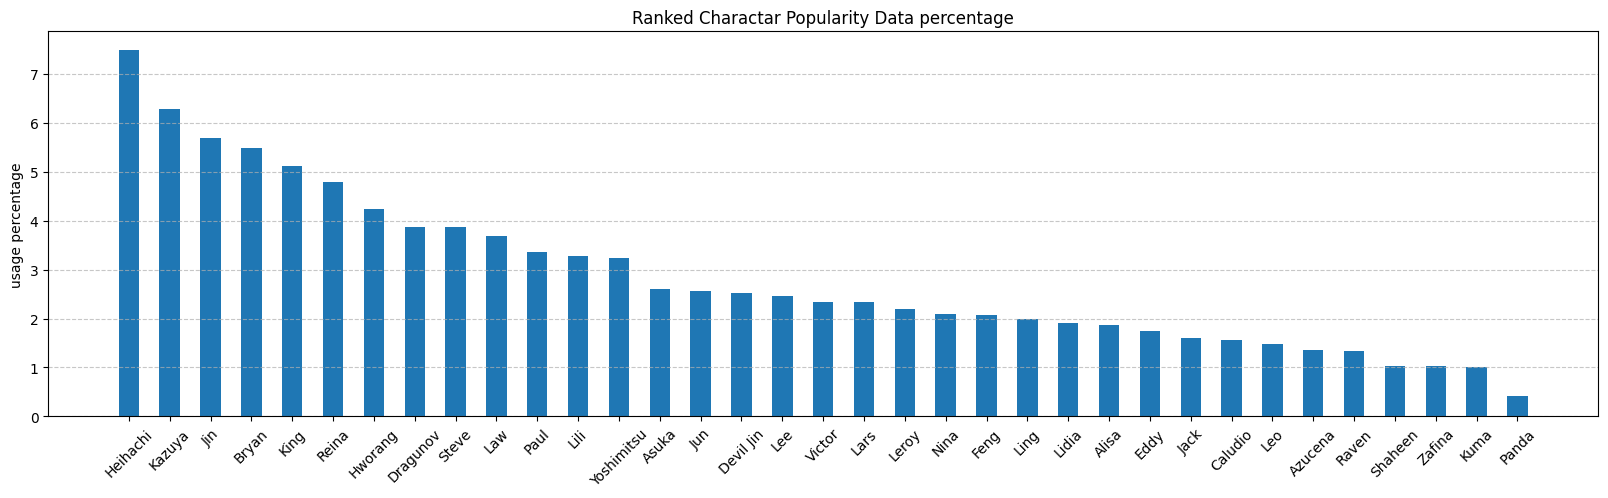

In [8]:
plot_data(most_pop_data, playable_char_map, unused_idxs, "Ranked Charactar Popularity Data", percentage=True)

In [9]:
rank_data = get_ranked_data(data)

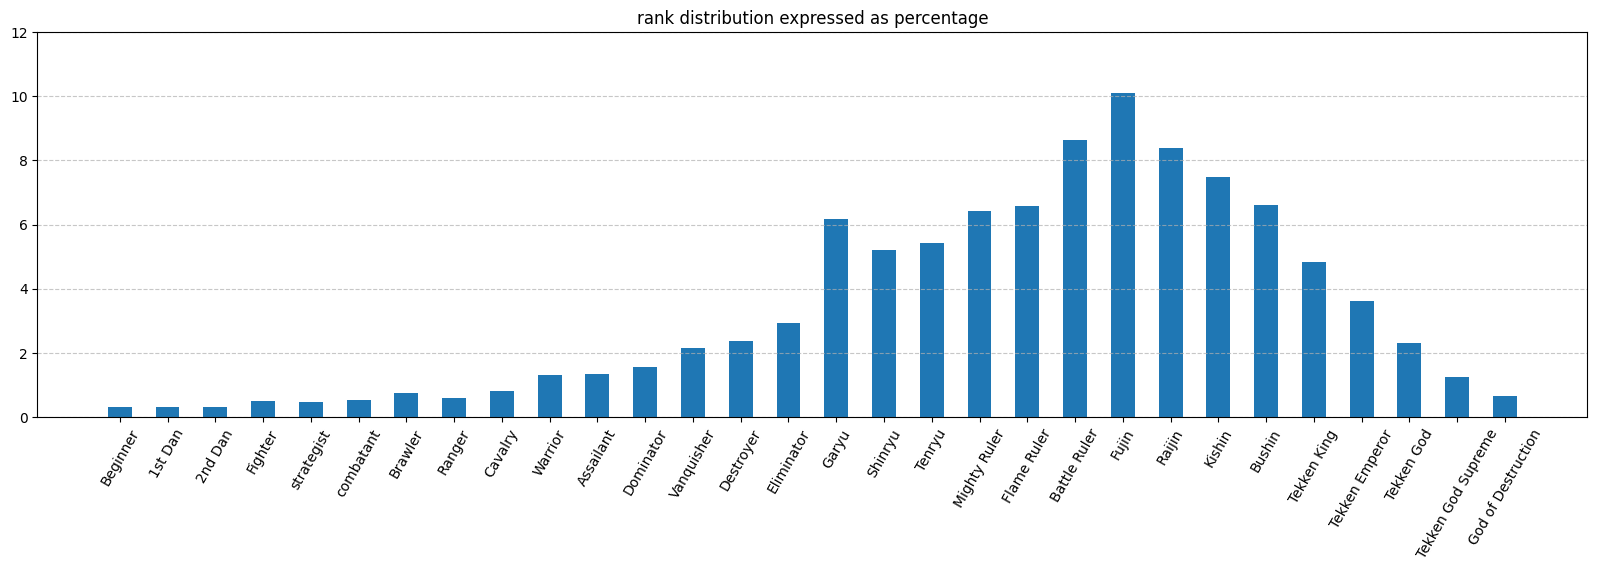

In [10]:
plot_rank_data(rank_data, rank_mapping, True)

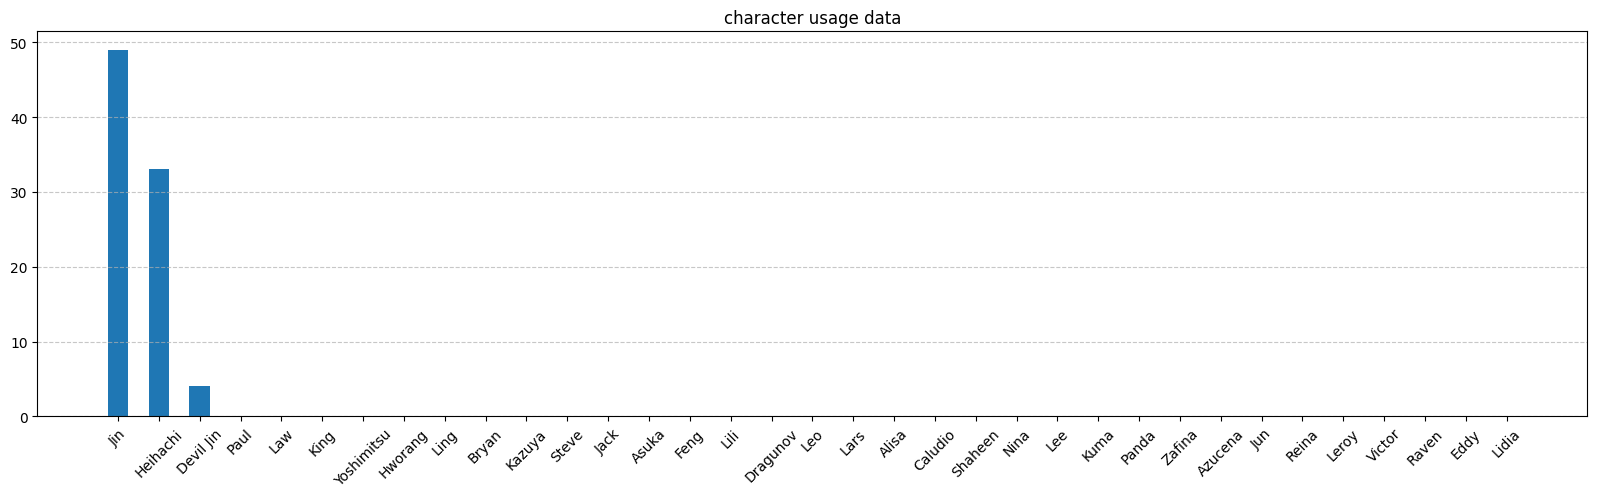

In [11]:
#find replays for a specific user, doesnt work right for the console players for some reason :/
rando, _ = find_all_replays_for_id("glonki", data, None)
plot_user_most_used_chars_data(rando, playable_char_map, unused_idxs)

In [12]:
char_usage_all_ranks, char_wins_all_ranks = get_chars_global_winrates(data, playable_char_map)

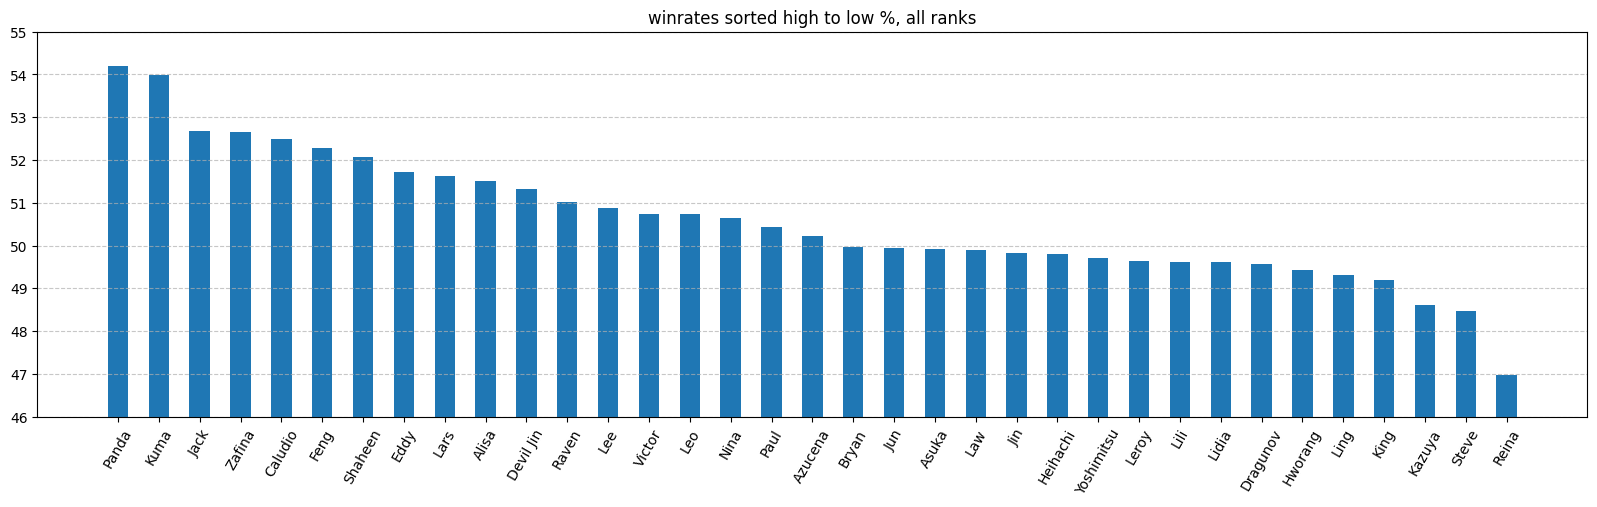

In [13]:
plot_global_char_winrates(char_usage_all_ranks, char_wins_all_ranks, unused_idxs, playable_char_map, "winrates sorted high to low %, all ranks", True)

In [14]:
indv_matchups = get_chars_ind_matchups_winrates(data, playable_char_map, unused_idxs)

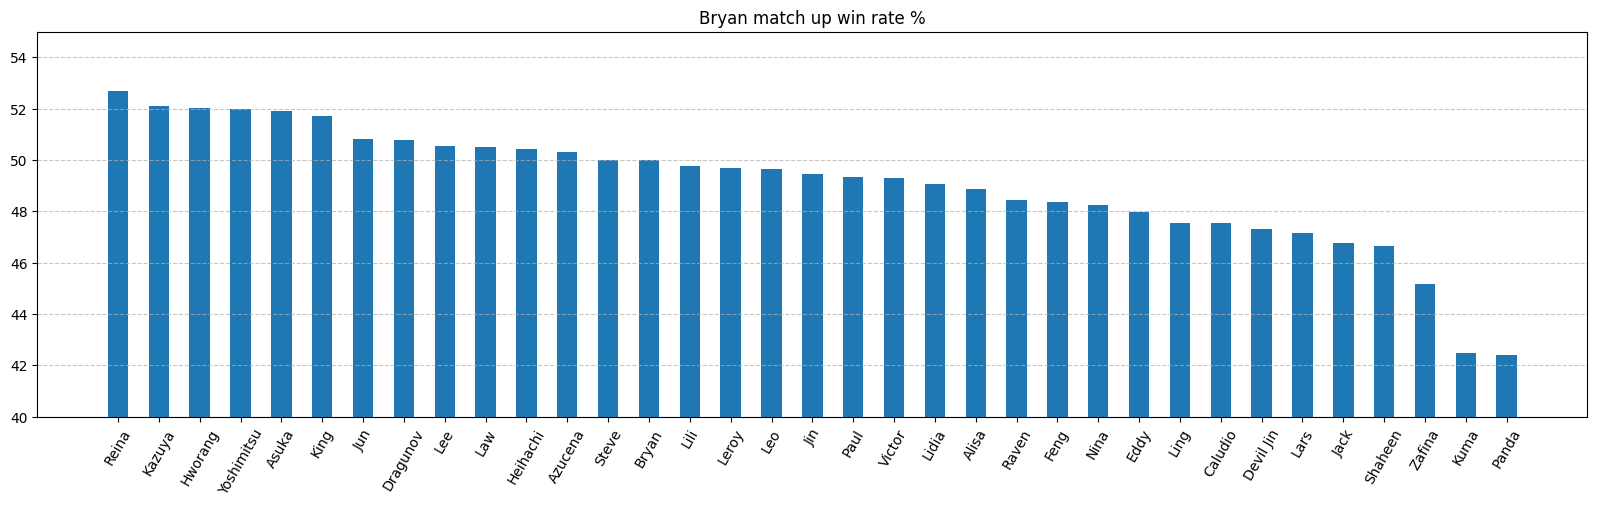

In [15]:
plot_char_matchup_winrates(indv_matchups["Bryan"], playable_char_map, unused_idxs, "Bryan match up win rate %", sort=True)

In [16]:
fujin_onwards_data = filter_data_based_on_rank(data, reverse_rank_map["Fujin"])

In [17]:
most_pop_fujin_onwards, _ = find_char_popularity(fujin_onwards_data, playable_char_map)

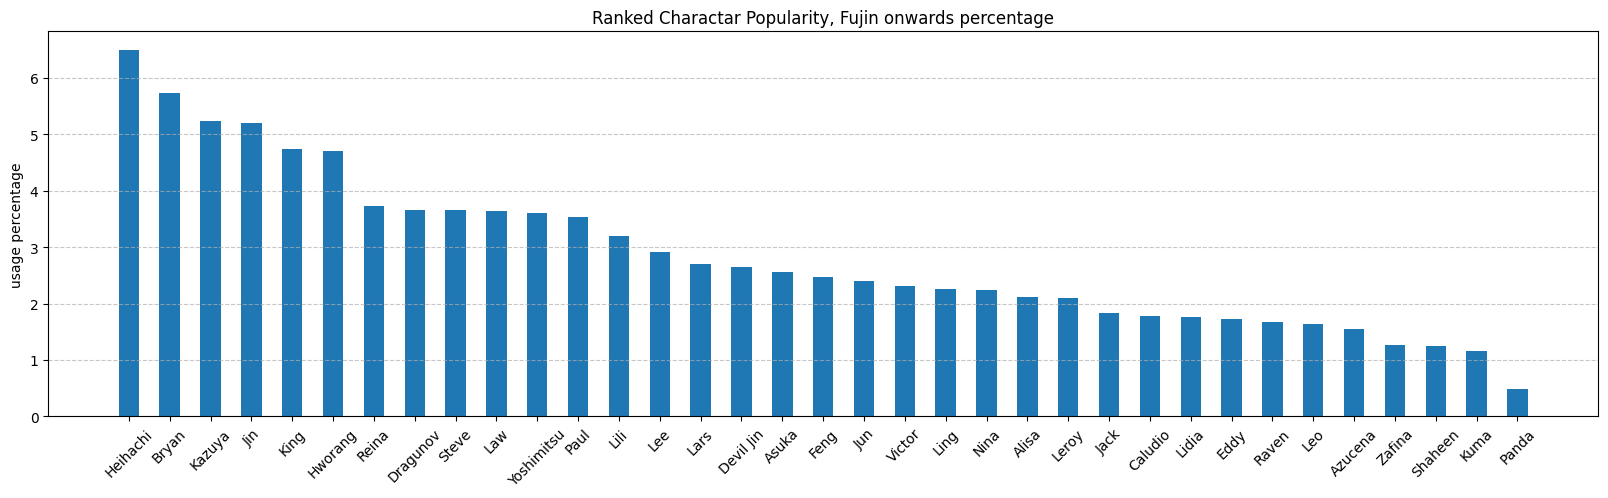

In [18]:
plot_data(most_pop_fujin_onwards, playable_char_map, unused_idxs, "Ranked Charactar Popularity, Fujin onwards", True)

In [19]:
char_usage_Fujin_onwards, char_wins_Fujin_onwards = get_chars_global_winrates(fujin_onwards_data, playable_char_map)

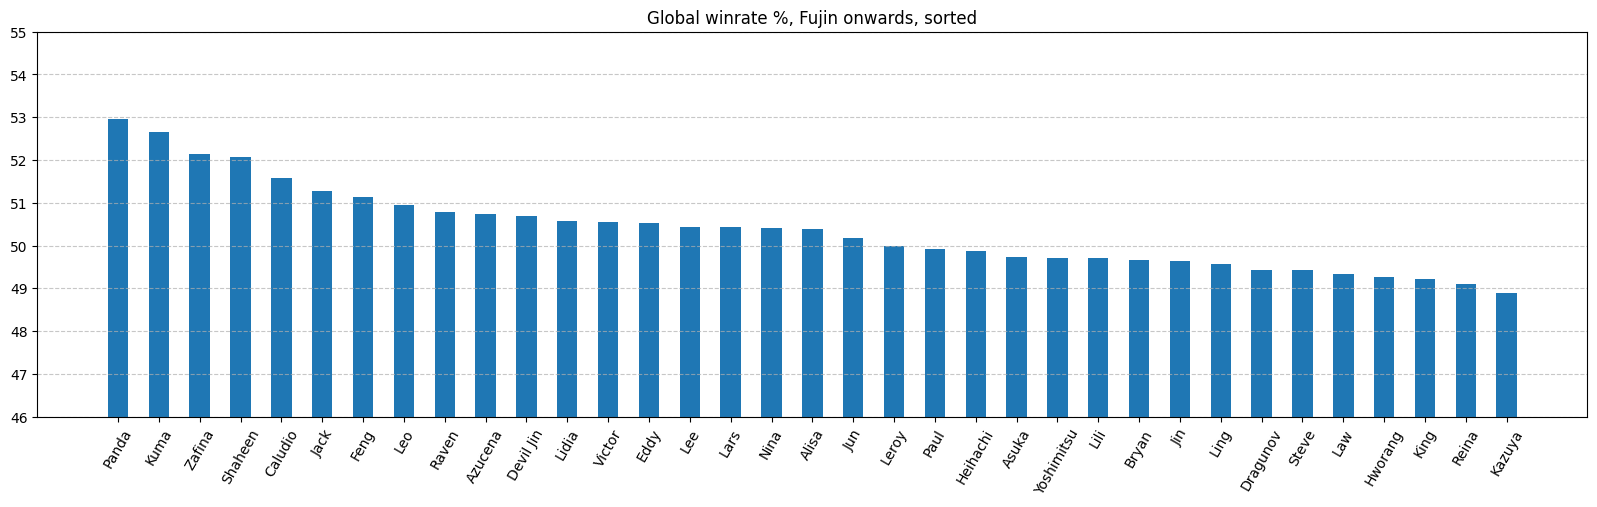

In [20]:
plot_global_char_winrates(char_usage_Fujin_onwards, char_wins_Fujin_onwards, unused_idxs, playable_char_map, "Global winrate %, Fujin onwards, sorted", True)

In [21]:
god_rank_data = filter_data_based_on_rank(data, 25, 29)
most_pop_god_ranks, _ = find_char_popularity(god_rank_data, playable_char_map)
char_usage_god_ranks, char_wins_god_ranks = get_chars_global_winrates(god_rank_data, playable_char_map)

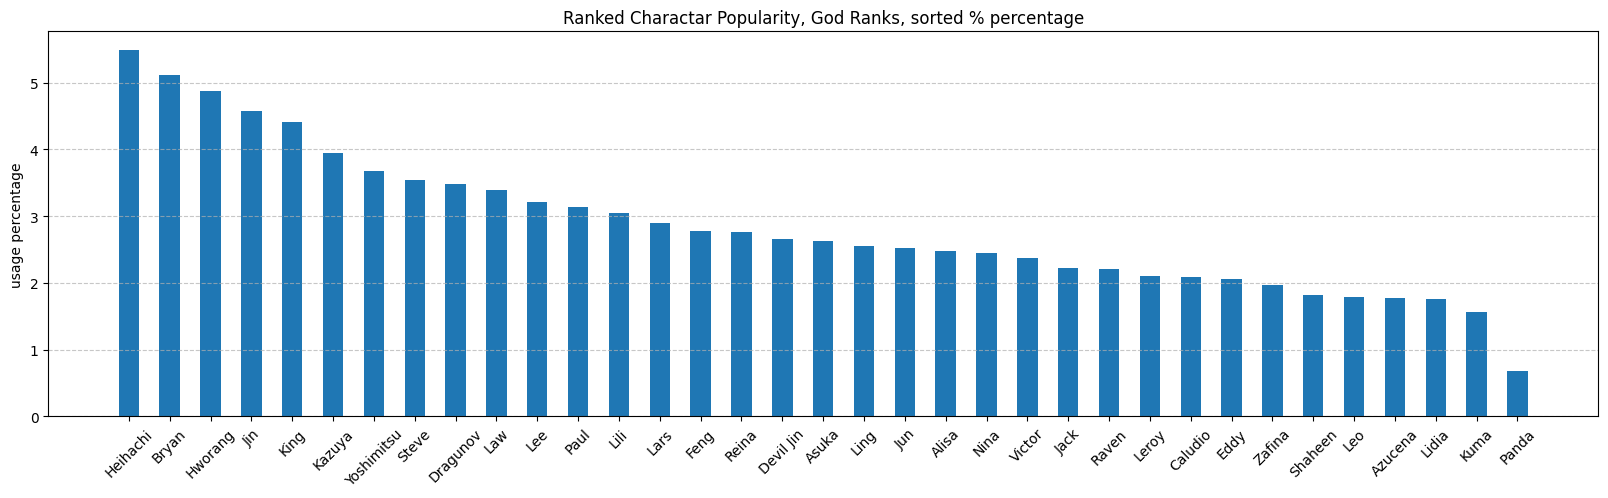

In [22]:
plot_data(most_pop_god_ranks, playable_char_map, unused_idxs, "Ranked Charactar Popularity, God Ranks, sorted %", True)

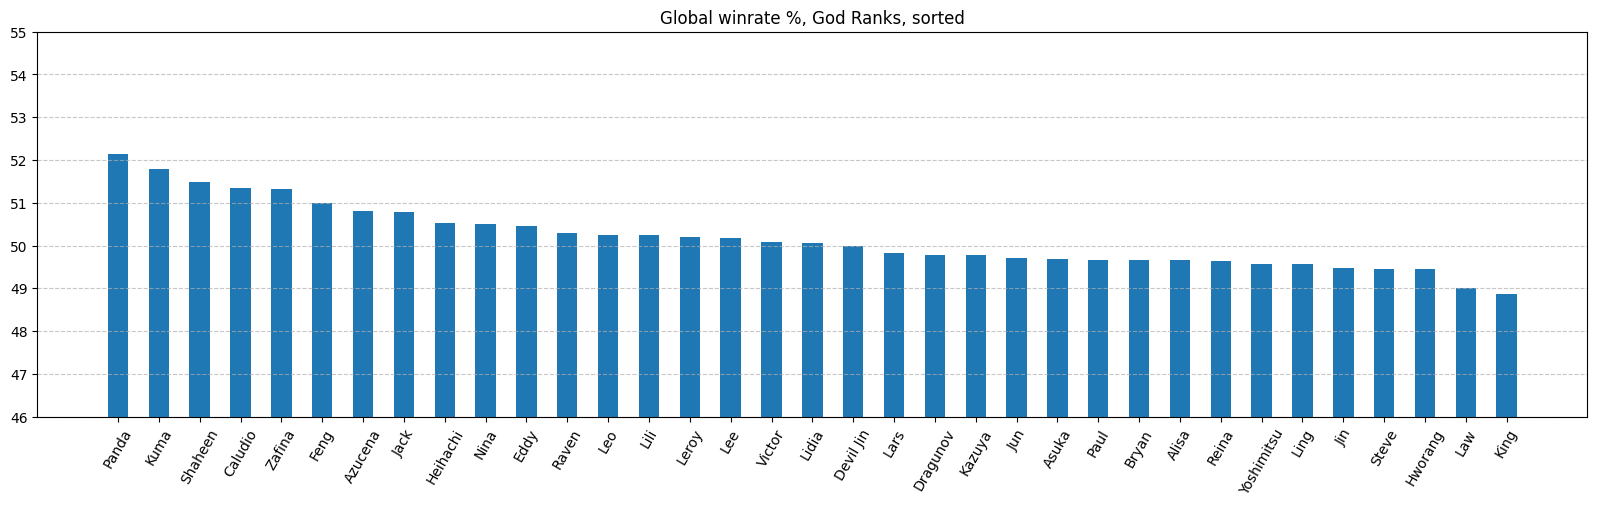

In [23]:
plot_global_char_winrates(char_usage_god_ranks, char_wins_god_ranks, unused_idxs, playable_char_map, "Global winrate %, God Ranks, sorted", True)

In [30]:
matchup_winrates = head_to_head_char_win_rates(indv_matchups, playable_char_map, unused_idxs, reverse_char_map)

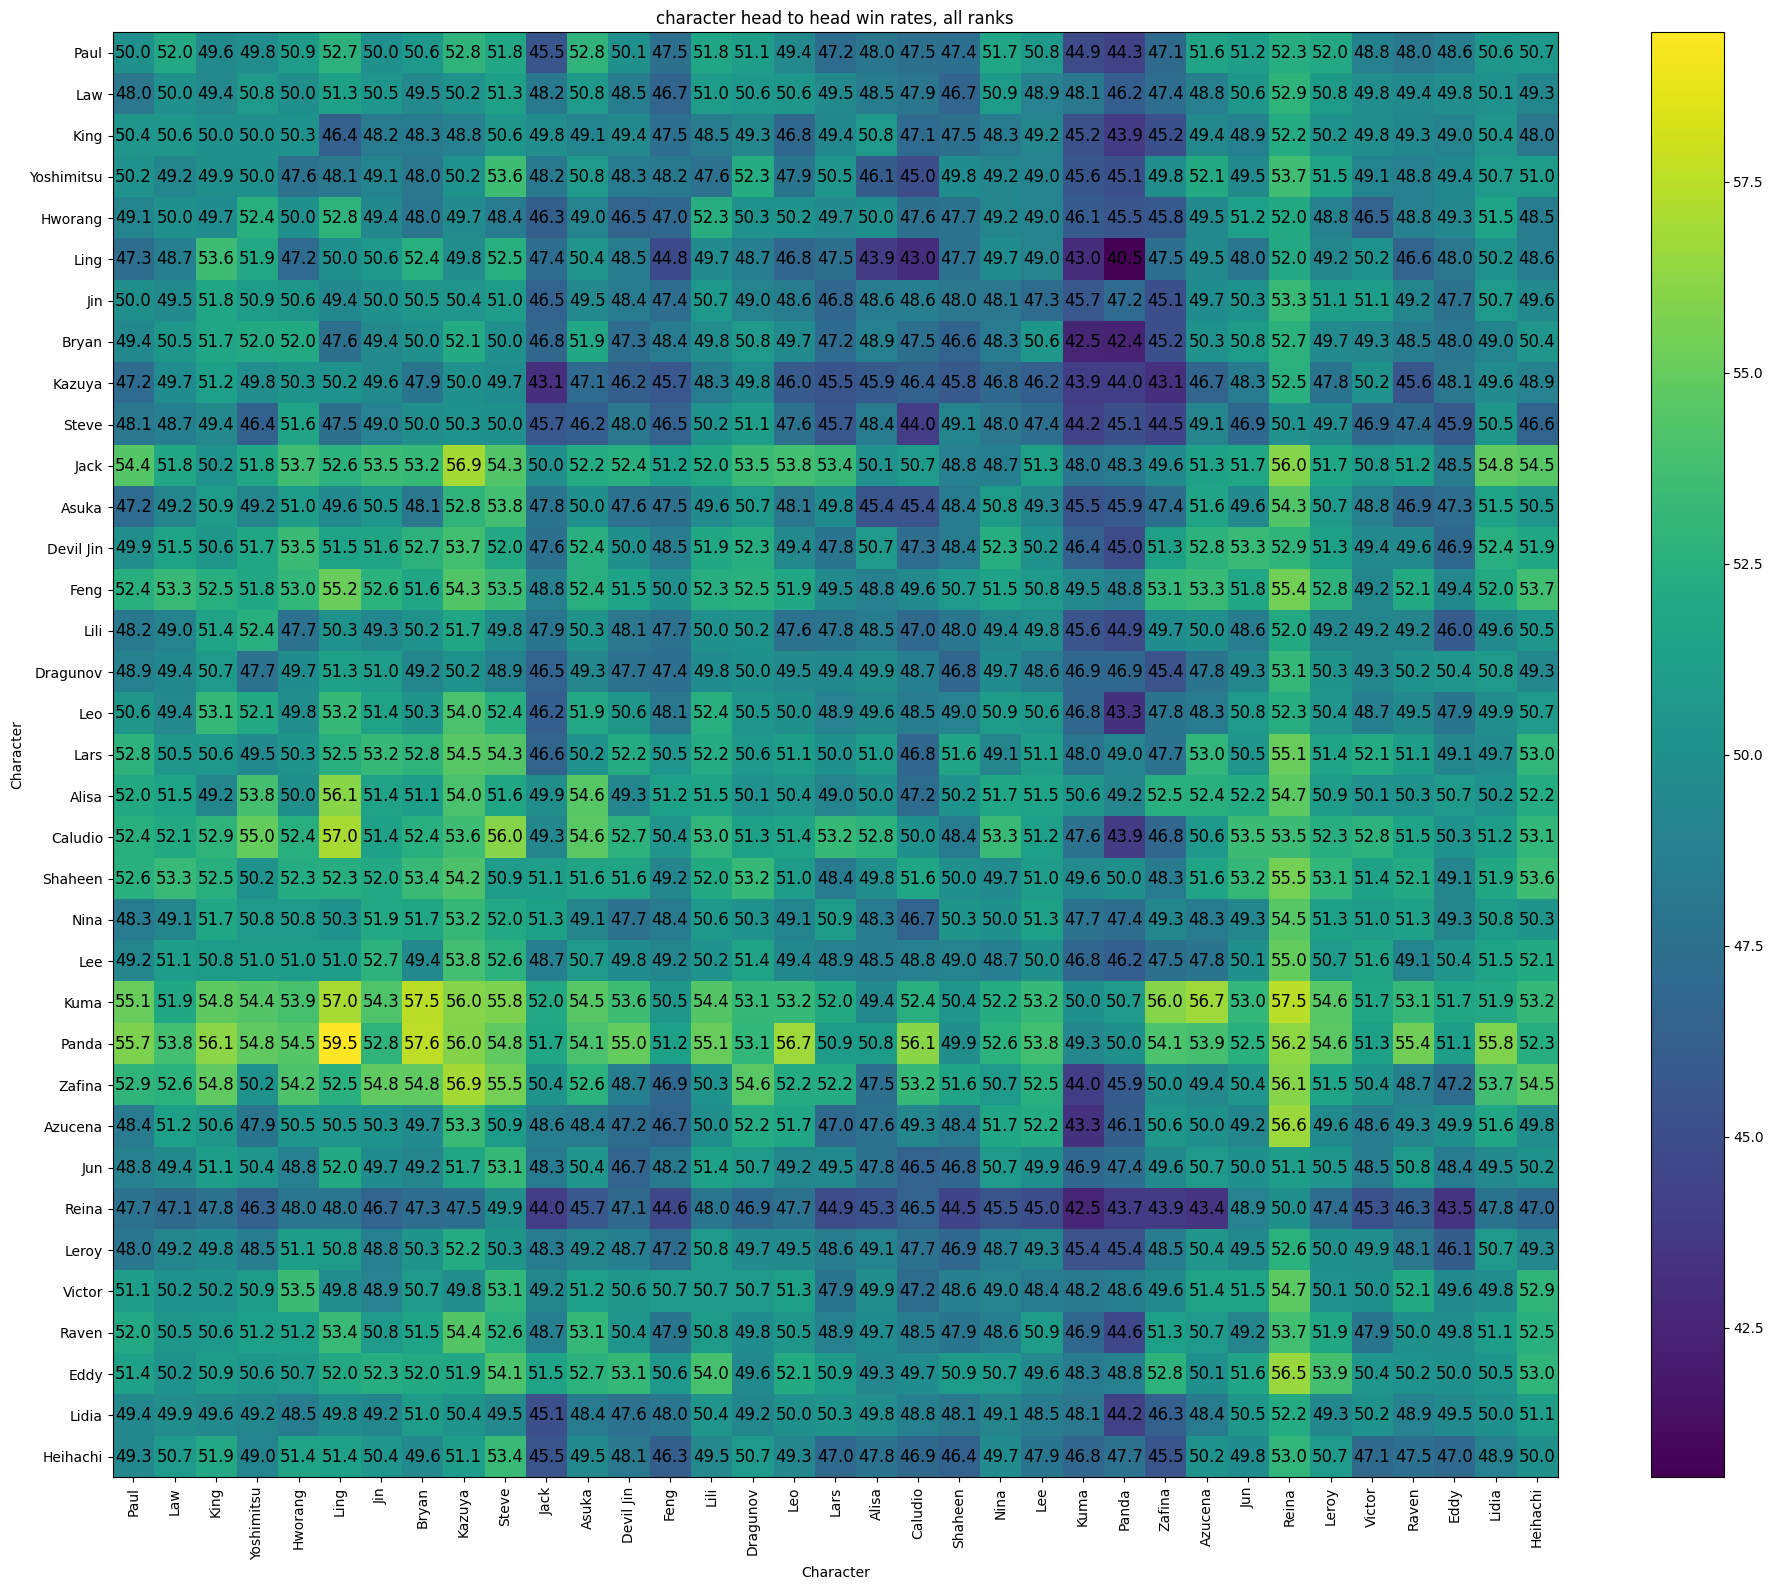

In [31]:
plot_heatmap(matchup_winrates, playable_char_map, unused_idxs, "character head to head win rates, all ranks")

In [32]:
indv_matchups_fujin = get_chars_ind_matchups_winrates(fujin_onwards_data, playable_char_map, unused_idxs)
indv_matchups_god_ranks = get_chars_ind_matchups_winrates(god_rank_data, playable_char_map, unused_idxs)

In [34]:
matchup_winrates_fujin = head_to_head_char_win_rates(indv_matchups_fujin, playable_char_map, unused_idxs, reverse_char_map)
matchup_winrates_god_ranks = head_to_head_char_win_rates(indv_matchups_god_ranks, playable_char_map, unused_idxs, reverse_char_map)

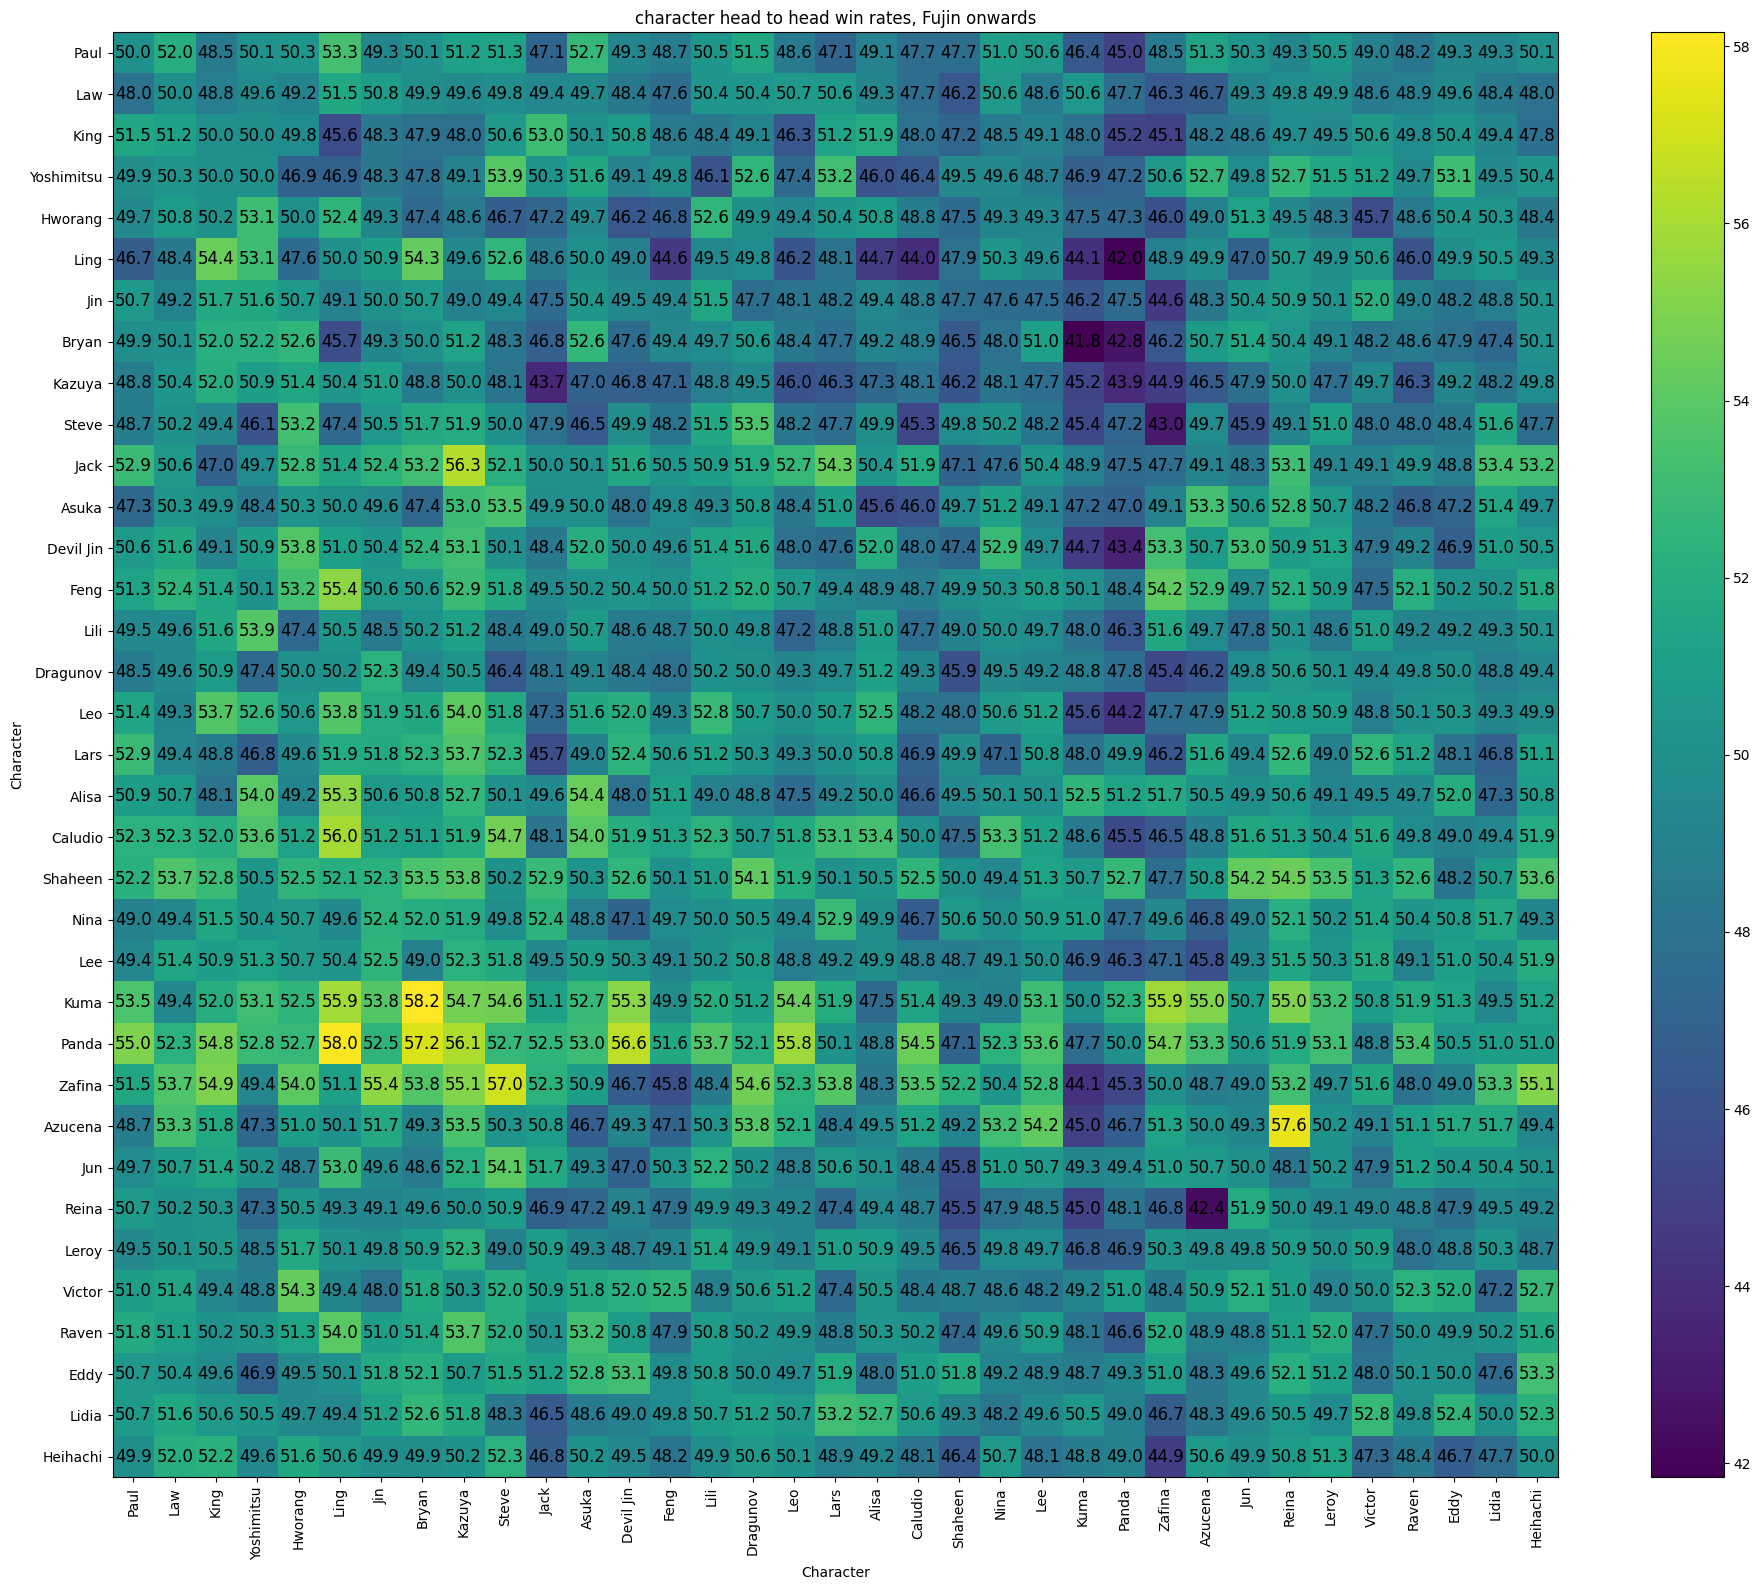

In [35]:
plot_heatmap(matchup_winrates_fujin, playable_char_map, unused_idxs, "character head to head win rates, Fujin onwards")

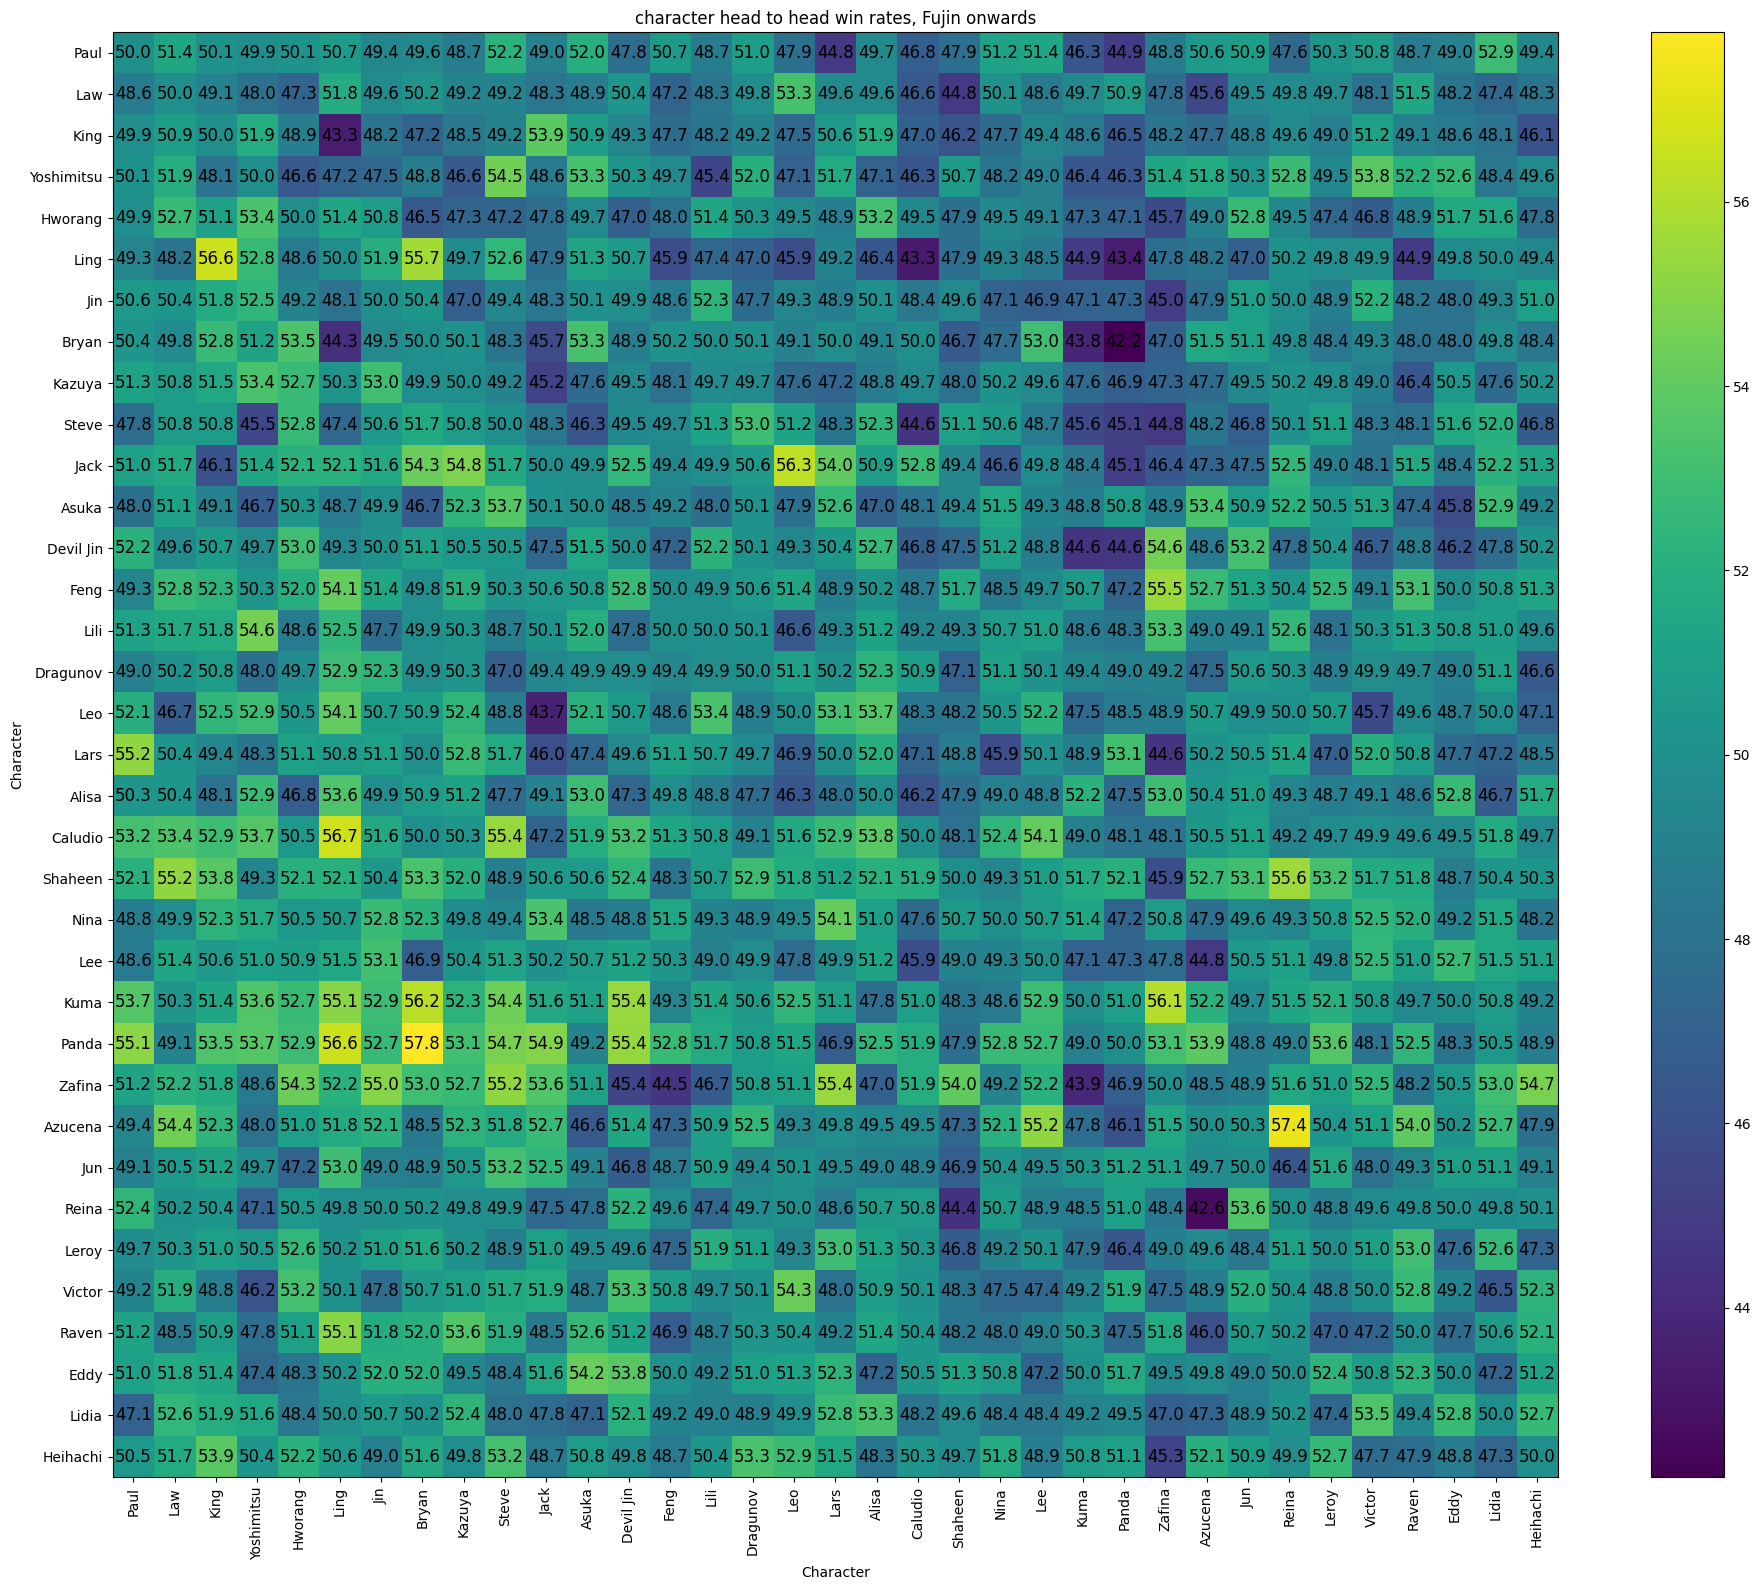

In [ ]:
plot_heatmap(matchup_winrates_god_ranks, playable_char_map, unused_idxs, "character head to head win rates, God ranks")